In [1]:
import torch
import emoji
import os
import sys
import pandas as pd
import numpy as np
import scipy.stats as ss
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.insert(0, '../')

from tqdm import tqdm
from config import GPT2EmojiConfig
from model import GPT2LMEmojiModel
from transformers import GPT2Tokenizer
from run_language_modeling import load_and_cache_examples, targets_mask
from sst_binary import sst_binary
from utils import *
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


MODEL_CLASSES = {
    "gpt2": (GPT2EmojiConfig, GPT2LMEmojiModel, GPT2Tokenizer),
}

MODEL_PATH = '../checkpoint-180000'

args = torch.load(os.path.join(MODEL_PATH, 'training_args.bin'))

config_class, model_class, tokenizer_class = MODEL_CLASSES['gpt2']

config = config_class.from_pretrained(MODEL_PATH)

tokenizer = tokenizer_class.from_pretrained(MODEL_PATH)

model = model_class.from_pretrained(
            MODEL_PATH,
            config=config,
)

map_target_to_token_id = dict(
        zip(range(0, len(emoji.UNICODE_EMOJI.keys())), tokenizer.encode(list(emoji.UNICODE_EMOJI.keys())))
)


Bad key "text.kerning_factor" on line 4 in
/home/jkarabl/anaconda3/envs/emoji-gpt2/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution
Token indices sequence length is longer than the specified maximum sequence length for this model (2811 > 1024). Running this sequence through the model will result in indexing errors


In [2]:
DATASETS = [
    'Olympic',
    'PsychExp',
    'SCv1',
    'SCv2-GEN',
    'SE0714',
    'SS-Twitter',
    'SS-Youtube',
]
DIR = '../data'
FILENAME_RAW = 'raw.pickle'
CLASSES = 'negative & high control, positive & high control, negative & low control, positive & high control'.split(', ')
TRAIN_SIZE = 250

In [3]:
def load_dataset(dataset):
    print(dataset)
    DATASET_PATH = f'{DIR}/{dataset}/{FILENAME_RAW}'
    with open(DATASET_PATH, 'rb') as file:
        data = pickle.load(file, fix_imports=True, encoding='bytes')
    
    # Decode data
    texts = [str(x) for x in data[b'texts']]
    # Extract labels
    labels = [x[b'label'] for x in data[b'info']]
    return texts, labels

def decode(y_in):
    y_out = []
    for y in y_in:
        y_out.append(np.argmax(y))
    return y_out

In [4]:
X, y = load_dataset(DATASETS[0])
y = decode(y)

Olympic


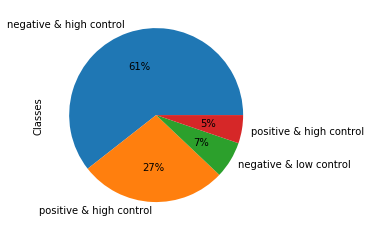

In [5]:
df = pd.DataFrame({'X': X, 'y': y})
ax = df.y.value_counts().plot.pie(labels=CLASSES, autopct='%1.0f%%')
ax.set_ylabel('Classes')
plt.savefig('Olympic-classes.pdf', dpi=300)

In [10]:
pd.set_option('display.width', 1000)

In [13]:
df.loc[df.y == 0, 'X']

9       .@t0kii re.  8,652 positive opinions http://j....
10      those japanese handstands are insane. pierre y...
11      bloody hell epke zonderland! after all that dr...
13      the gymnastics has been so impressive, don't g...
18      both korea and japan are dissapointing this ye...
                              ...                        
991     maksymenko "had a fumble with the ribbon befor...
1000    sad that maksymenk lost the ball, that was a g...
1002    oh no, no bronze medal for alina. everyone lov...
1005    oh ffs rhythmic  team finals meant to be on tv...
1007    watching a replay of the women's group all-aro...
Name: X, Length: 277, dtype: object

In [5]:
Xt = tokenize(X, tokenizer)

In [6]:
trXt, teXt, trY, teY = train_test_split(Xt, y, train_size=TRAIN_SIZE, random_state=42)

In [7]:
mean_preds = predict_mean(trXt, model, tokenizer, map_target_to_token_id)

100%|██████████| 250/250 [00:18<00:00, 13.66it/s]


In [8]:
last_preds = predict_last(trXt, model, tokenizer, map_target_to_token_id)

100%|██████████| 250/250 [00:17<00:00, 13.99it/s]


In [9]:
max_preds = predict_max(trXt, model, tokenizer, map_target_to_token_id)

100%|██████████| 250/250 [00:17<00:00, 14.70it/s]


In [10]:
mean_cm = pd.crosstab(pd.Series(mean_preds), pd.Series(trY))
mean_cm

col_0,0,1,2,3
row_0,,,,
✨,0,3,0,0
🏆,0,1,0,0
👀,1,0,0,0
👇,0,2,0,0
👉,0,2,0,0
👍,0,1,0,0
👏,1,19,0,0
💕,0,1,0,0
💖,0,1,0,0


In [11]:
last_cm = pd.crosstab(pd.Series(last_preds), pd.Series(trY))
last_cm

col_0,0,1,2,3
row_0,,,,
✨,1,9,0,0
❤,0,1,0,0
🌊,0,1,0,0
🎉,0,1,0,0
🎶,0,0,0,1
🏀,1,0,0,0
🏆,1,4,0,0
👀,2,4,0,0
👇,1,4,0,1


In [12]:
max_cm = pd.crosstab(pd.Series(max_preds), pd.Series(trY))
max_cm

col_0,0,1,2,3
row_0,,,,
✅,0,1,0,0
✨,1,6,0,0
🍆,0,1,0,0
🏀,1,0,0,0
🏆,0,6,0,0
🐐,14,21,2,2
👀,2,2,0,0
👇,4,9,0,0
👉,1,0,0,0


In [13]:
cramers_corrected_stat(mean_cm.to_numpy())

0.11667511224672211

In [14]:
cramers_corrected_stat(last_cm.to_numpy())

0.20167103405462053

In [15]:
cramers_corrected_stat(max_cm.to_numpy())

0.0

In [16]:
theil_u(trY, mean_preds)

0.11969018748688671

In [17]:
theil_u(trY, last_preds)

0.2179991267066016

In [18]:
theil_u(trY, max_preds)

0.17182423129507915

## Logreg

In [19]:
Xtrans_last = transform_last(X, model, tokenizer, args)

100%|██████████| 1012/1012 [01:12<00:00, 13.93it/s]


In [20]:
Xtrans_mean = transform_mean(X, model, tokenizer, args)

100%|██████████| 1012/1012 [01:11<00:00, 14.14it/s]


In [21]:
Xtrans_max = transform_max(X, model, tokenizer, args)

100%|██████████| 1012/1012 [01:13<00:00, 13.80it/s]


In [22]:
trXtrans, teXtrans, trY, teY = train_test_split(Xtrans_last, y, train_size=TRAIN_SIZE, random_state=42)

In [23]:
lr, C, scores = train_with_reg_cv(trXtrans, trY, teXtrans, teY, None, None, penalty='l2', solver='lbfgs', metrics='f1')
lr, C, scores

(LogisticRegression(C=0.25, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=1000000,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=51, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 0.25,
 [0.4207020087025065,
  0.426018471659919,
  0.4207236432868747,
  0.4142515008461331,
  0.4250781938271483,
  0.42090328649687514,
  0.4301553470864616,
  0.42614023312430543,
  0.42389038190736467])

In [24]:
trXtrans, teXtrans, trY, teY = train_test_split(Xtrans_mean, y, train_size=TRAIN_SIZE, random_state=42)

In [25]:
lr, C, scores = train_with_reg_cv(trXtrans, trY, teXtrans, teY, None, None, penalty='l2', solver='lbfgs', metrics='f1')
lr, C, scores

(LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=1000000,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=51, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 1.0,
 [0.40789280712329834,
  0.4074218321764669,
  0.4176381528221045,
  0.41807774270089304,
  0.4189967304046919,
  0.4161164392301299,
  0.41272822729714653,
  0.42344224403047936,
  0.42566793157664873])

In [26]:
trXtrans, teXtrans, trY, teY = train_test_split(Xtrans_max, y, train_size=TRAIN_SIZE, random_state=42)

In [27]:
lr, C, scores = train_with_reg_cv(trXtrans, trY, teXtrans, teY, None, None, penalty='l2', solver='lbfgs', metrics='f1')
lr, C, scores

(LogisticRegression(C=0.0625, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=1000000,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=51, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 0.0625,
 [0.36235632183908045,
  0.37275128718871153,
  0.39830666142303967,
  0.39871422576373233,
  0.40240618841627046,
  0.4019058340245685,
  0.39820402021787893,
  0.3926931567292102,
  0.3901222688779777])

## Vanilla GPT-2

In [28]:
from transformers import GPT2Model

In [29]:
model_version = 'gpt2'
model_gpt2 = GPT2Model.from_pretrained(model_version)
tokenizer_gpt2 = GPT2Tokenizer.from_pretrained(model_version)

In [30]:
Xtrans_gpt2 = transform_gpt2(X, model_gpt2, tokenizer_gpt2)

100%|██████████| 1012/1012 [01:10<00:00, 14.34it/s]


In [31]:
trXtrans, teXtrans, trY, teY = train_test_split(Xtrans_gpt2, y, train_size=TRAIN_SIZE, random_state=42)

lr, C, scores = train_with_reg_cv(trXtrans, trY, teXtrans, teY, None, None, penalty='l2', solver='lbfgs', metrics='f1')
lr, C, scores

(LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=1000000,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=51, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 1.0,
 [0.2250606518758131,
  0.2622907739585845,
  0.283918458159963,
  0.2948578469103835,
  0.313363247473961,
  0.31357987400721754,
  0.31129093097741595,
  0.3145607182575139,
  0.3279550562705401])

In [32]:
Xtrans_emoji = transform_emoji(X, model, tokenizer)

100%|██████████| 1012/1012 [01:12<00:00, 13.98it/s]


In [33]:
trXtrans, teXtrans, trY, teY = train_test_split(Xtrans_emoji, y, train_size=TRAIN_SIZE, random_state=42)

lr, C, scores = train_with_reg_cv(trXtrans, trY, teXtrans, teY, None, None, penalty='l2', solver='lbfgs', metrics='f1')
lr, C, scores

(LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=1000000,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=51, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 0.5,
 [0.38937195850185613,
  0.4032518564356436,
  0.4185273873976911,
  0.4180528634635499,
  0.4228986961633802,
  0.4146654069770277,
  0.41258953626016737,
  0.42321144289481494,
  0.4224630665904514])